# Temat: Analiza danych dotyczących udaru mózgu
    
    autor: Maciej Krakowiak

#### Załadowanie niezbędnych modułów

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer, f1_score, recall_score, precision_score, fbeta_score, ConfusionMatrixDisplay, confusion_matrix


#### Ustawienie ziarna dla reprodukowalności osiągniętych rezultatów

In [2]:
rng = 2030
np.random.seed(rng)
seed = np.random.RandomState(rng)

#### Ustawienia wykresów

In [3]:
sns.set(
    rc={
        "figure.dpi": 100,
        "savefig.dpi": 300,
        "figure.figsize": (9, 9),
    }
)

### Ładowanie danych

In [4]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

#### Pierwszy rzut oka na dane

In [5]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Czyszczenie danych

Sprawdzenie czy występują brakujące wartości.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Można zauważyć, że w kolumnie 'bmi' znajduje się 201 brakujących wartości.

In [7]:
(5110 - 4909) / 5110

0.03933463796477495

Brakujące wartości stanowią zaledwie 3.9% wszystkich wartości

#### Podgląd podstawowych miar statystycznych kolumn

Dla całości danych:

In [8]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Dla danych, w których wierszach znajdują się wartości brakujące 'bmi':

In [9]:
df[df['bmi'].isna()].describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,201.000000,201.000000,201.000000,201.000000,201.000000,0.0,201.000000
mean,23171.109453,52.049154,0.233831,0.164179,126.724627,NaN,0.199005
std,20882.483120,22.276181,0.424323,0.371363,59.240322,NaN,0.400249
min,67.000000,0.480000,0.000000,0.000000,57.520000,NaN,0.000000
25%,4062.000000,37.000000,0.000000,0.000000,81.430000,NaN,0.000000
50%,18234.000000,58.000000,0.000000,0.000000,99.870000,NaN,0.000000
75%,37937.000000,71.000000,0.000000,0.000000,191.790000,NaN,0.000000
max,72231.000000,82.000000,1.000000,1.000000,260.850000,NaN,1.000000


#### Ponieważ brakujące wartości 'bmi' zdają się być wartościami MCAR (missing completely at random), a stanowią mniej niż 4% danych, postanowiłem dokonać imputacji za pomocą mediany

In [10]:
df.fillna(value=df['bmi'].median(), inplace=True)

In [11]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

## Eksploracyjna analiza danych - EDA

In [12]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#### Ujednolicenie systemu nazw kolumn
Dla ułatwienia przyszłej eksploracji danych - wszystkie kolumny mają zaczynać się z małej litery

In [13]:
df.rename(columns= {'Residence_type' : 'residence_type'}, inplace=True)

#### Ustawienie kolumny 'id' jako indeksu

In [14]:
df.set_index('id', inplace=True)

#### Zaznajomienie się z rozkładem kategorii w zmiennych kategorycznych

In [15]:
categorical_columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status', 'stroke']
for column in categorical_columns:
    print(df[column].value_counts())

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
0    4612
1     498
Name: hypertension, dtype: int64
0    4834
1     276
Name: heart_disease, dtype: int64
Yes    3353
No     1757
Name: ever_married, dtype: int64
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
Urban    2596
Rural    2514
Name: residence_type, dtype: int64
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64
0    4861
1     249
Name: stroke, dtype: int64


##### Aby uniknąć niepotrzebnych anomalii w modelowaniu, postanowiłem wprowadzić następujące zmiany:
    'gender': kategorię 'Other' (1 rekord) zmienić na najczęściej występującą kategorię ('Female')
    'work_type': kategorię 'Never_worked' (22 rekordy) zmienić na najczęściej występującą kategorię ('Private')

In [16]:
ind = df.query('gender == "Other"').index
df.loc[ind, 'gender'] = 'Female'

In [17]:
for ind in df.query('work_type == "Never_worked"').index:
    df.loc[ind, 'work_type'] = 'Private'

In [18]:
df['gender'].value_counts()

Female    2995
Male      2115
Name: gender, dtype: int64

In [19]:
df['work_type'].value_counts()

Private          2947
Self-employed     819
children          687
Govt_job          657
Name: work_type, dtype: int64

#### Kodowanie zmiennych kategorycznych

Przyglądając się danym można zwrócić uwagę na to, że mamy przewagę zmiennych kategorycznych (gender, hypertension, heart_disease, ever_married, work_type, Residence_type, smoking_status), jednak tylko niektóre z nich (hypertension, heart_disease, stroke) są zakodowane liczbowo, aby móc przyjrzeć się korelacjom i rozważyć możliwość usunięcia niektórych kolumn należy ujednolicić kodowanie zmiennych kategorycznych

LabelEncoder dla zmiennych, w których kolejność kategorii nie ma znaczenia

OrdinalEncoder dla zmiennych (zmiennej 'Smoking_status'), dla których kolejność występowania kategorii ma znaczenie (jest hierarchia)

In [20]:
label = ['gender', 'ever_married', 'work_type', 'residence_type']
ordinal = ['smoking_status']

In [21]:
for col in label:
    df[col] = LabelEncoder().fit_transform(df[col])

In [22]:
df['smoking_status'] = OrdinalEncoder().fit_transform(df.loc[:, ['smoking_status']])

In [23]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,1,67.0,0,1,1,1,1,228.69,36.6,1.0,1
51676,0,61.0,0,0,1,2,0,202.21,28.1,2.0,1
31112,1,80.0,0,1,1,1,0,105.92,32.5,2.0,1
60182,0,49.0,0,0,1,1,1,171.23,34.4,3.0,1
1665,0,79.0,1,0,1,2,0,174.12,24.0,2.0,1


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   int32  
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   int32  
 5   work_type          5110 non-null   int32  
 6   residence_type     5110 non-null   int32  
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   float64
 10  stroke             5110 non-null   int64  
dtypes: float64(4), int32(4), int64(3)
memory usage: 528.3 KB


#### Zmienienie typu danych zawierających zmienne kategoryczne na 'category'

In [25]:
for column in categorical_columns:
    df[column] = df[column].astype('category')

In [26]:
df['age'] = df['age'].astype('int')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             5110 non-null   category
 1   age                5110 non-null   int32   
 2   hypertension       5110 non-null   category
 3   heart_disease      5110 non-null   category
 4   ever_married       5110 non-null   category
 5   work_type          5110 non-null   category
 6   residence_type     5110 non-null   category
 7   avg_glucose_level  5110 non-null   float64 
 8   bmi                5110 non-null   float64 
 9   smoking_status     5110 non-null   category
 10  stroke             5110 non-null   category
dtypes: category(8), float64(2), int32(1)
memory usage: 309.8 KB


#### Sprawdzenie czy w zbiorze występują wartości odstające

Text(0.5, 1.0, 'Boxplot dla wszystkich zmiennych')

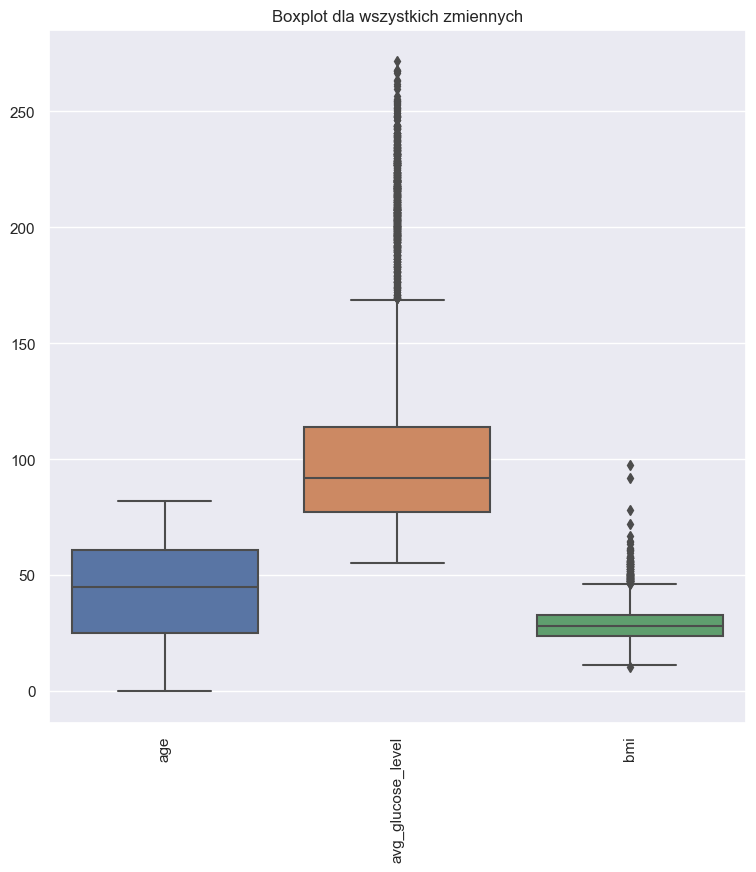

In [28]:
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title('Boxplot dla wszystkich zmiennych')

#### Przyjrzyjmy się bliżej kolumnom 'avg_glucose_level' oraz 'bmi'

##### 'avg_glucose_level'

Text(0.5, 1.0, 'Rozkład danych poziomu glukozy')

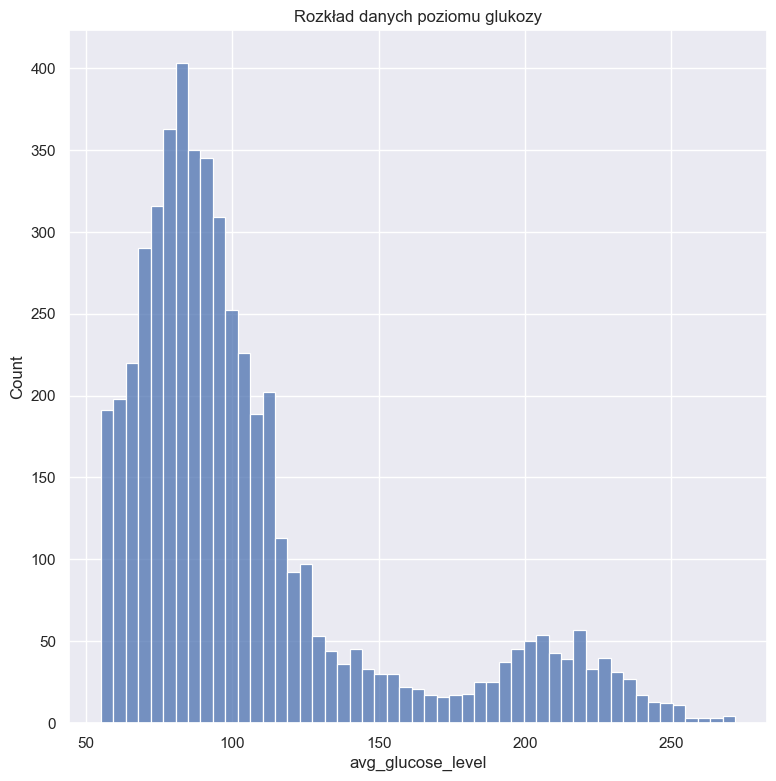

In [29]:
sns.histplot(data=df, x='avg_glucose_level')
plt.title('Rozkład danych poziomu glukozy')

Sprawdzenie rozkładu zmiennej celu dla potencjalnych outlierów sugerowanych przez metodę IQR

Text(0.5, 1.0, 'Ilość "stroke" dla danych, gdzie poziom glukozy > 160')

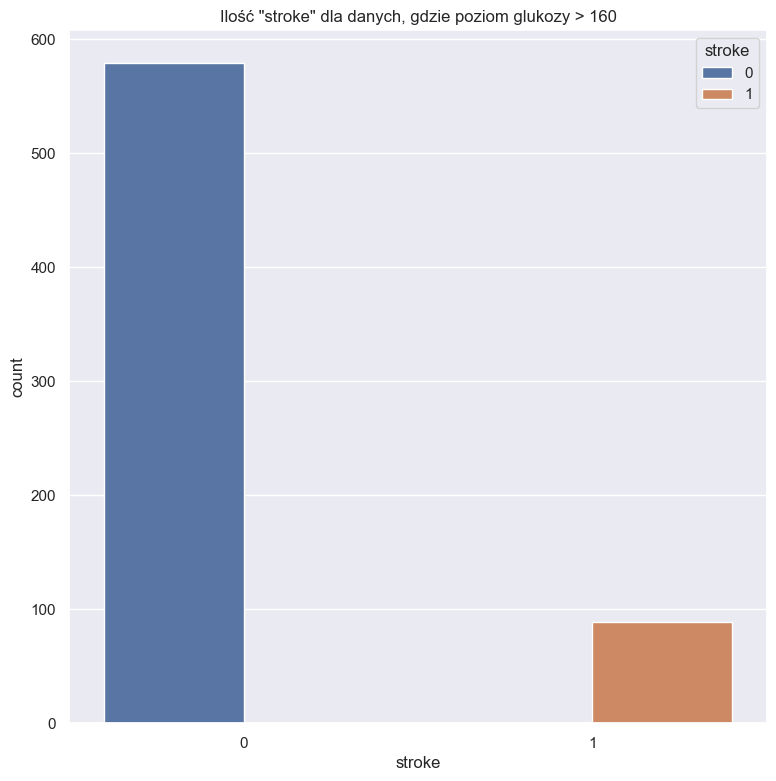

In [30]:
sns.countplot(data=df.query('avg_glucose_level > 160'), x='stroke', hue='stroke')
plt.title('Ilość "stroke" dla danych, gdzie poziom glukozy > 160')

Jak widać zasugerowanie się wartościami odstającymi pokazanymi przez boxplot wyeliminowało by ze zbioru znaczną część danych zmiennej celu, w których miał miejsce udar (~100/249)

Text(0.5, 1.0, 'Ilość "stroke" dla danych, gdzie poziom glukozy > 250')

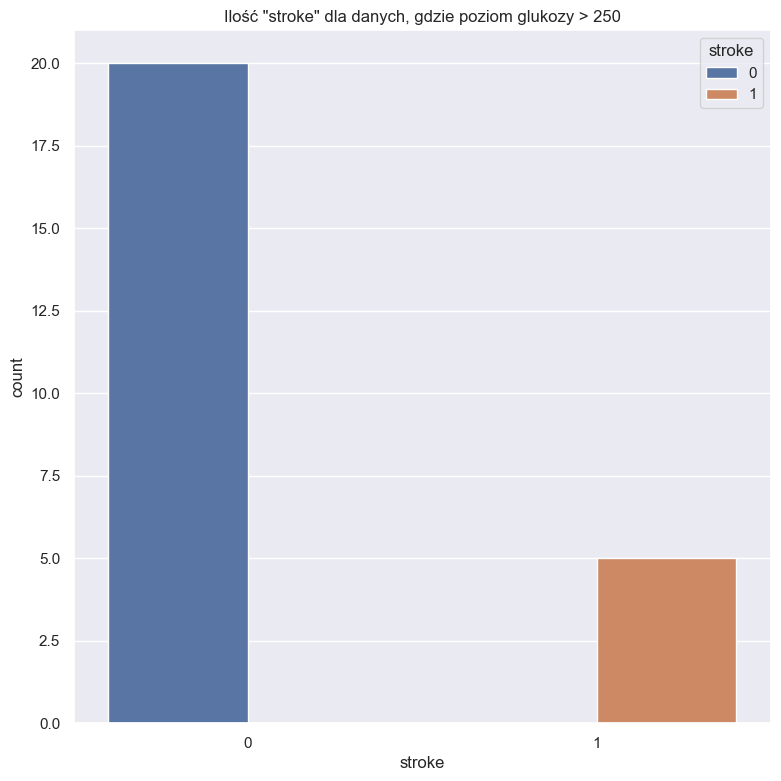

In [31]:
sns.countplot(data=df.query('avg_glucose_level > 250'), x='stroke', hue='stroke')
plt.title('Ilość "stroke" dla danych, gdzie poziom glukozy > 250')

Nawet wybierając skrajne wartości poziomu glukozy jak 250, dla 25 rekordów aż 5 posiada odnotowany udar. Ponieważ zmienna celu jest niezbalansowana (249 udarów na 5110 rekordów), postanawiam nie usuwać tych danych jako outliery, aby nie tracić danych zawierających pozytywnie odnotowany udar

##### 'bmi'

Text(0.5, 1.0, 'Rozkład danych wartości bmi')

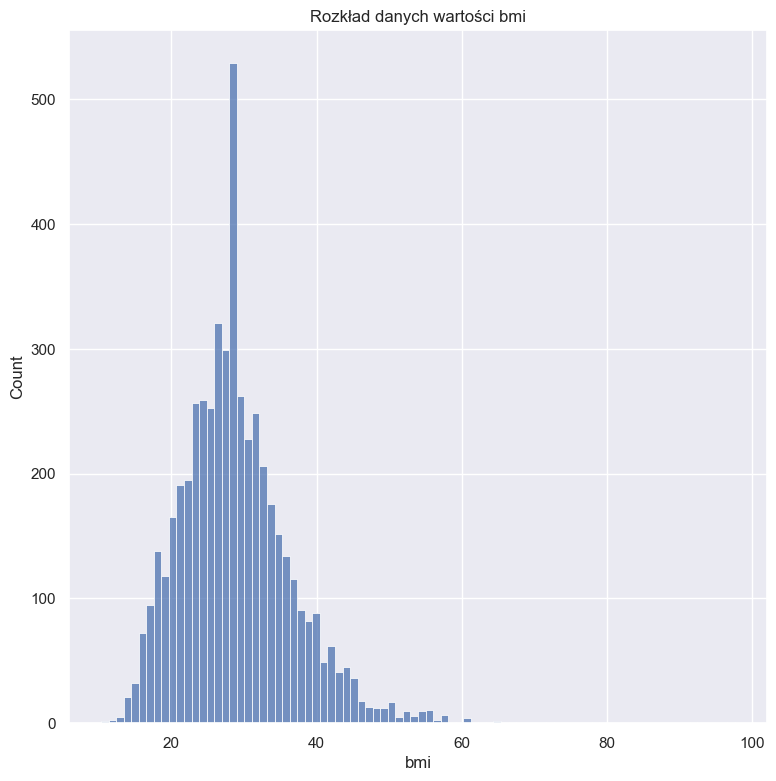

In [32]:
sns.histplot(data=df, x='bmi')
plt.title('Rozkład danych wartości bmi')

Text(0.5, 1.0, 'Ilość "stroke" dla danych, gdzie wartość bmi > 46')

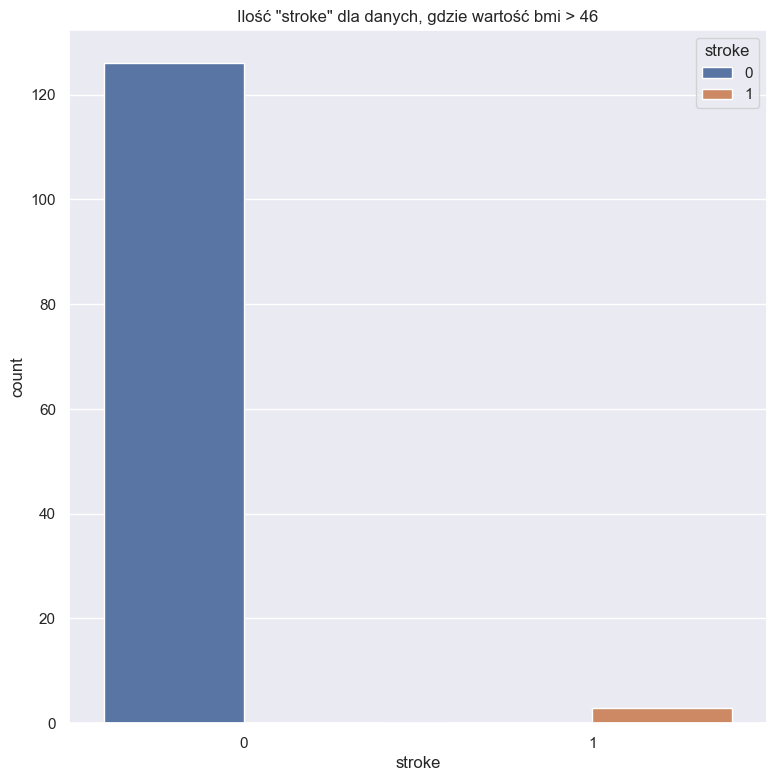

In [33]:
sns.countplot(data=df.query('bmi > 46'), x='stroke', hue='stroke')
plt.title('Ilość "stroke" dla danych, gdzie wartość bmi > 46')

W wypadku kolumny 'bmi' usunięcie wartości odstających wskazanych przez wykres pudełkowy (metoda IQR) spowoduje usunięcie nielicznej ilości rekordów zmiennej celu, gdzie odnotowano udar, dlatego podjąłem decyzję o usunięciu tych danych jako outliery.

In [34]:
outlier_mask = df['bmi'] > 46

In [35]:
df = df[~outlier_mask]

### Rozkład zmiennej celu

<AxesSubplot:xlabel='stroke', ylabel='count'>

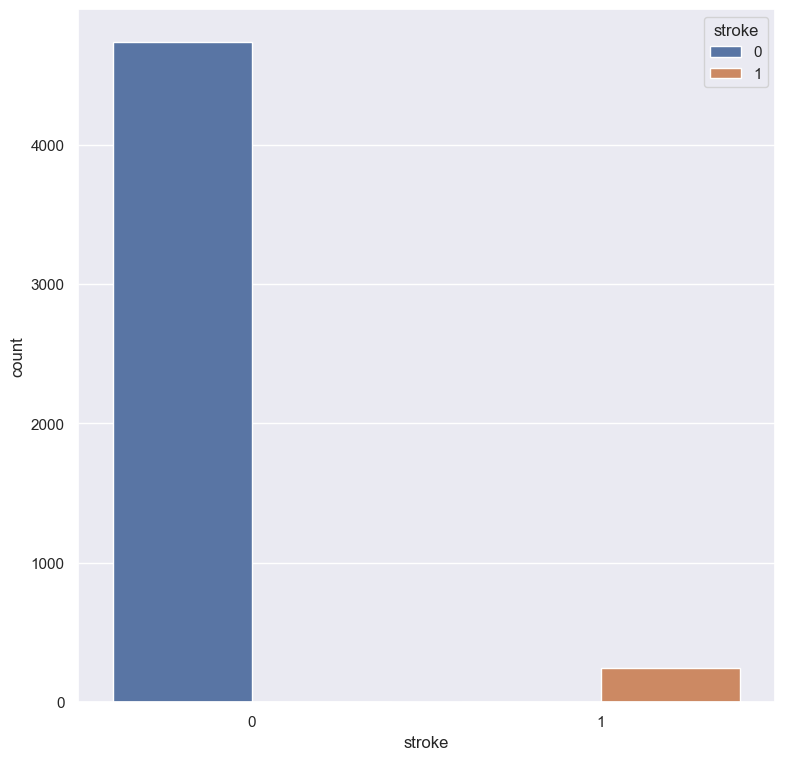

In [36]:
sns.countplot(data=df, x='stroke', hue='stroke')

In [37]:
(len(df[df['stroke'] == 1]) / len(df)) * 100

4.938767315800041

Dane, w których odnotowano wystąpienia udaru stanowią niecałe 5% danych, dlatego też nasz zbiór jest niezbalansowany. Będziemy musieli dobrać w związku z tym odpowiednią strategię do uczenia modelu, napewno będziemy musieli zadbać, żeby odpowiednia statystyka pojawiła się w zbiorze walidacyjnym (słowo kluczowe: stratify)

## Modelowanie danych

### Podzielenie danych na predyktory i zmienną celu

In [38]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

### Wyznaczenie zbioru treningowego i testowego

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng, stratify=y)

##### Następnie sprawdzam czy zachowane zostały proporcje rozkładu zmiennej celu (oryginalnie rekordy, w których odnotowano udar stanowiły 4,93% danych)

In [40]:
len(y_test[y_test==1]) / len(y_test) * 100

4.914744232698094

Proporcje zachowane, więc można przejść dalej

### Wybór modelu

Zacznijmy od wstępnej oceny modeli, tuningiem hiperparametrów zajmiemy się później. Stwórzmy kilka modeli i wybierzmy najbardziej obiecujący z nich:

    Baseline:
        uniform: zgadywanie z jednakowym prawdopodobieństwem
        strarified: zgadywanie z prawdopodobieństwem odpowiadającym rozłożeniu klas
        majority: zgadywanie, zawsze podawana jest klasa większościowa (w tym przypadku osoby bez udaru)
        
    LogisticRegression:
        Najprostszy i najbardziej oczywisty model do zastosowania w klasyfikacji binarnej
        
    DecisionTree:
        Prosty w interpretacji klasyfikator, wytypowany w rozważaniach nad zbiorem niezbalansowanym
        
    RandomForrest:
        Klasyfikator wytypowany w rozważaniach nad zbiorem niezbalansowanym
        
    GradientBoosting:
        Klasyfikator wytypowany w rozważaniach nad zbiorem niezbalansowanym
        
Modele Baseline posłużą nam jako punkt odniesienia. Nie możemy zejść poniżej wyników uzyskiwanych przez te modele, ponieważ w takim przypadku bardziej opłacalne byłoby zgadywanie.

In [41]:
models = {
    "Baseline-uniform": DummyClassifier(strategy="uniform", random_state=seed),
    "Baseline-stratified": DummyClassifier(
        strategy="stratified", random_state=seed
    ),
    "Baseline-majority": DummyClassifier(
        strategy="most_frequent", random_state=seed
    ),
    "LogisticRegression": LogisticRegression(
        class_weight="balanced",random_state=seed,
        max_iter=1000,
        # musiałem podbić max_iter do 1000,
        # inaczej ConvergenceWarning:
        #    lbfgs failed to converge (status=1): STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
    ),
    "DecisionTree": DecisionTreeClassifier(
        random_state=seed, class_weight="balanced"
    ),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=seed),
    "RandomForrest": RandomForestClassifier(
        random_state=seed, class_weight='balanced'
    ),
}

##### Zastanówmy się chwilę nad metrykami. Na których nam zależy? Co chcemy zmaksymalizować?

Accuracy:
    
    Metryka bezużyteczna w naszym zbiorze (niezbalansowany), tylko zgadując na podstawie klasy większościowej uzyskamy wynik 95%

Precision:
    
    Metryka, którą prawdopodobnie chcielibyśmy zmaksymalizować w celu minimalizacji błędu I rodzaju (predykcja udaru dla osoby bez udaru. Liczona wzorem True Positive / (True Positive + False Positive)
    
Recall:
    
    Metryka, którą prawdopodobnie także chcielibyśmy zmaksymalizować w celu minimalizacji błędu II rodzaju (predykcja braku udaru dla osoby z udarem. Liczona wzorem True Positive / (True Positive + False Negative)
Ściągawka dla False Negative i False Positive:


|  | Rzeczywisty udar (1) | Rzeczywisty brak udaru (0) |
| :- | -: | :-: |
| Predykcja udar (1) | True Positive | False Positive |
| Predykcja brak udaru (0) | False Negative | True Negative 



Błąd I rodzaju: False Positive

Błąd II rodzaju: False Negative


Wybierając tylko jedną z tych metryk prawdopodobnie możemy skończyć maksymalizując jedną, i bardzo zmniejszając drugą. Z pomocą przychodzi nam metryka Fbeta, która jest średnią harmoniczną z Precision i Recall, może pomóc zmaksymalizować obie naraz. Mamy kilka metryk rodzajów Fbeta: (opisy na podstawie: https://machinelearningmastery.com/fbeta-measure-for-machine-learning/)

F05

    bardziej zależy nam na Recall
    przydatne, gdy chcemy zminimalizować liczbę False Positives
        tzn. mniej zdrowych pacjentów z predykcją udaru

F1

    Recall i Precision są tak samo istotne
    czyli próbujemy zminilaizować zarówno błędy I rodzaju jak i II rodzaju

F2

    Precision jest ważniejsze od Recall
    Przydatne, gdy chcemy zminializować liczbę False Negatives
    tzn. mniej osób z udarem oznaczanych jako osoby zdrowe (bez udaru)

W dalszej części projektu skupimy się na maksymalizacji F1.

Mimo wyboru metryki, zeewalujumy modele na wszystkich - edukacyjnie, sprawdźmy jak się zachowują.


#### Ewaluacja modeli z domyślnymi parametrami na wskazanych metrykach

In [42]:
def fit_classifier(alg, X_train, X_test, y_train, y_test):
    alg.fit(X_train, y_train)
    y_pred_train = alg.predict(X_train)
    y_pred_test = alg.predict(X_test)
    
    return {
        "ACC_train":round(accuracy_score(y_train, y_pred_train),2),
        "ACC_test": round(accuracy_score(y_test, y_pred_test),2),
        "P_train":  round(precision_score(y_train, y_pred_train, zero_division=0),2),
        "P_test":   round(precision_score(y_test, y_pred_test, zero_division=0),2),
        "R_train":  round(recall_score(y_train, y_pred_train, zero_division=0),2),
        "R_test":   round(recall_score(y_test, y_pred_test, zero_division=0),2),
        "F05_train":round(fbeta_score(y_train, y_pred_train, beta=0.5, zero_division=0),2),
        "F05_test": round(fbeta_score(y_test, y_pred_test, beta=0.5, zero_division=0),2),
        "F1_train": round(f1_score(y_train, y_pred_train, zero_division=0),2),
        "F1_test":  round(f1_score(y_test, y_pred_test, zero_division=0),2),
        "F2_train": round(fbeta_score(y_train, y_pred_train, beta=2, zero_division=0),2),
        "F2_test":  round(fbeta_score(y_test, y_pred_test, beta=2, zero_division=0),2)
    }

In [43]:
results = pd.DataFrame()
for name, model in models.items():
    params = [name]
    res = [fit_classifier(model,
                          X_train, X_test, y_train, y_test)]
    df_results = pd.DataFrame(res, index=params)
    results = results._append(df_results)

In [44]:
results.sort_values(['F1_test'], ascending=False)

,ACC_train,ACC_test,P_train,P_test,R_train,R_test,F05_train,F05_test,F1_train,F1_test,F2_train,F2_test
LogisticRegression,0.74,0.73,0.14,0.12,0.82,0.71,0.17,0.14,0.24,0.21,0.42,0.36
DecisionTree,1.00,0.92,1.00,0.15,1.00,0.14,1.00,0.15,1.00,0.14,1.00,0.14
GradientBoostingClassifier,0.96,0.95,1.00,0.50,0.17,0.04,0.50,0.15,0.29,0.08,0.20,0.05
Baseline-stratified,0.90,0.91,0.05,0.07,0.05,0.06,0.05,0.07,0.05,0.07,0.05,0.06
Baseline-uniform,0.50,0.48,0.05,0.03,0.54,0.33,0.06,0.04,0.10,0.06,0.19,0.11
RandomForrest,1.00,0.95,1.00,0.25,0.99,0.02,1.00,0.08,1.00,0.04,1.00,0.02
Baseline-majority,0.95,0.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Jak widać model LogisticRegression poradził sobie najlepiej dla metryki F1, dodatkowo uzyskał znacznie lepsze wyniki dla metryk jak Recall, a do tego nie występuje tu zjawisko overfittingu. W dalszej części projektu zajmiemy się optymalizacją parametrów dla tego modelu.

In [45]:
logreg = LogisticRegression(class_weight="balanced", random_state=seed, max_iter=1000)

In [46]:
logreg.fit(X, y)

LogisticRegression(class_weight='balanced', max_iter=1000,
                   random_state=RandomState(MT19937) at 0x1C3020E7040)

In [47]:
y_pred_train = logreg.predict(X_train)
y_pred_test = logreg.predict(X_test)

Text(0.5, 1.0, 'Confusion matrix dla zbioru treningowego')

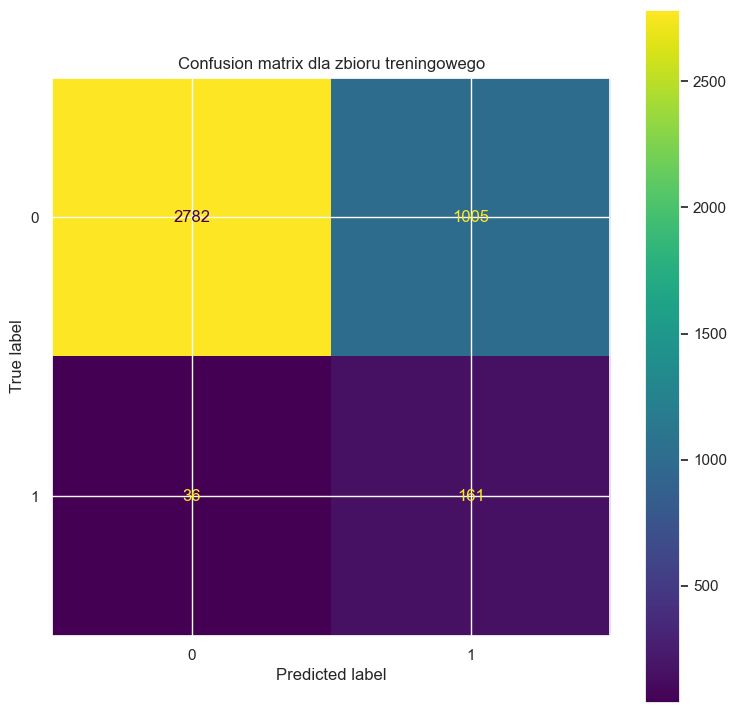

In [48]:
cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion matrix dla zbioru treningowego')

Text(0.5, 1.0, 'Confusion matrix dla zbioru testowego')

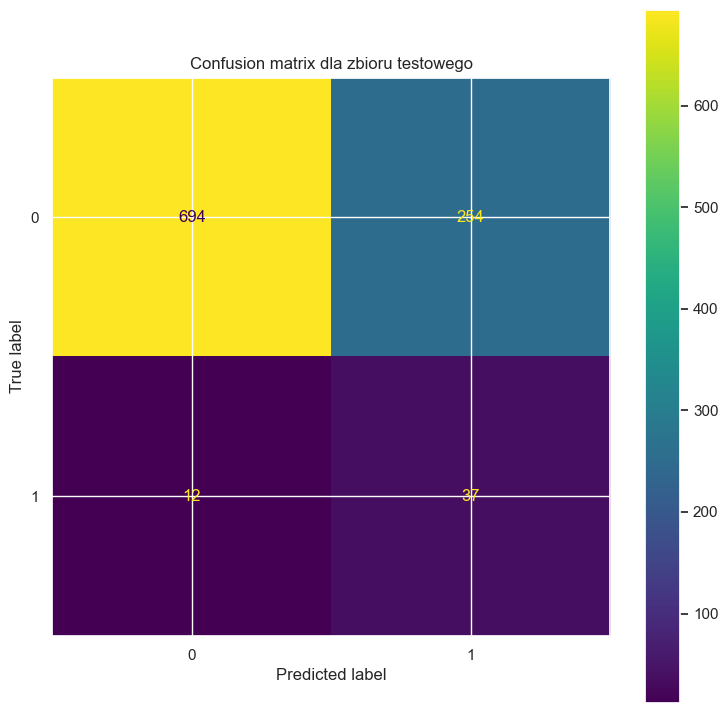

In [49]:
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion matrix dla zbioru testowego')

Po analizie macierzy błędów można zauważyć, że predykcja wyników przynosi bardzo dużo błędów I rodzaju (czyli osoby zdrowe, którym przewidujemy udar), stąd też słaby wynik metryki Precision, który przekłada się na pogorszenie wyników metryk fbeta.

W dalszej optymalizacji hiperparametrów modelu naszym celem będzie zmniejszenie ilości błędów I rodzaju, co wpłynie na polepszenie wyników metryk precision, a tym samym fbeta, a w szczególności metryki do której maksymalizacji dążymi, czyli f1.

## Tuning Hiperparametrów

In [50]:
logreg.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': RandomState(MT19937) at 0x1C3020E7040,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [51]:
f1 = make_scorer(f1_score, zero_division=0)

In [52]:
params = {
 'C': np.logspace(-4, 4, 20),
 'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga', 'newton-cholesky'],
 'penalty': ['l1', 'l2', 'elasticnet', None],
 'max_iter': [1000, 2500, 5000]
}

In [53]:
#gs = GridSearchCV(logreg, params, scoring=f1).fit(X,y)

In [54]:
#best_params = gs.best_params_
#best_params

In [55]:
#oryginalne parametry GridSearchCV (zakomentowane w celu redukcji czasu uruchamiania pliku)
best_params = {'C': 0.004832930238571752, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'sag'}

In [56]:
#gs.best_score_

In [57]:
#oryginalny wynik GridSearchCV
best_score = 0.24412638139237722

Optymalizacja parametrów poprzez GridSearchCV nieznacznie zwiększyła wynik metryki f1

## Wnioski

Mając do dyspozycji zbiór danych, w którym zmienna celu jest klasyfikacją binarną o proporcjach rozkładu 95/5, naturalną rzeczą jest, że jest się w stanie osiągać wysokie wyniki predykcji dla metryki accuracy i to też miało miejsce dla wielu modeli.
Jednak taki wynik nie powinien nikogo satysfakcjonować. Dla dobra pacjentów nie powinno się cieszyć z sytuacji, w której każdą osobę definiujemy jako zdrową i szczycimy się 95% skutecznością, mimo że w rzeczywistości może mieć jakąś bardziej dotkliwą diagnozę.

Powinno dążyć się do sytuacji, gdzie, albo celność predykcji to 100% albo minimalizować błędy I i II rodzaju.

Dlatego też analizując model skupiono uwagę na metrykach Precision, Recall oraz F1. Wybrany model regresji logistycznej osiągał najwyższe wyniki dla Recall oraz F1, jednak wyniki Precision oraz F1 nie były satysfakcjonujące (kolejno 0.12 i 0.21).

Model w satysfakcjonującym stopniu potrafił przewidzieć udar wśród osób, które faktycznie miały udar (mała ilość błędów II rodzaju, dlatego wynik metryki Recall wynosił dla zbioru testowego 0.71).
Miał on jednak problemy z poprawnym przewidywaniem braku udaru wśród osób, które go faktycznie nie miały (tłumaczy to bardzo niski wynik Precision, a co za tym idzie F1).

Idąc tym tropem, z dwojga złego można powiedzieć, że lepiej, aby model, który potencjalnie ma służyć jako narzędzie pomocnicze dla lekarza, alarmował o ryzyku udaru dla osób, u których faktycznie ono występuje, mimo że przy okazji ostrzeże o ryzyku dla kilku osób zdrowych, niżeli model miałby uznawać każdą osobę jako zdrową.

Można by rzec, że lepiej zapobiegać niż leczyć, przez co oznakowanie osoby zdrowej jako osoby, która może mieć udar ma mniejsze konsekwencje niż oznakowanie osoby z udarem jako osoby bez ryzyka jego wystapienia.

Podsumowując model może mieć problemy ze zdefiniowaniem osoby "zdrowej", może to wynikać z niewystarczającej ilości predyktorów, które pomogły by w tym zadaniu. Jednak spełnia swoją funkcję lepiej niż modele, które zakładają, że każda osoba jest bez ryzyka udaru (i tym samym mają 95% poprawnych predykcji), a dzieje się tak ze względu na to, że w 70% poprawnie przewiduje udar wśród osób, które rzeczywiście go miały. Mimo to, aby uzyskać model perfekcyjny, który osiągał by jeszcze lepsze, zadowalające wyniki, w zbiorze danych może brakować jeszcze kilku istotnych predyktorów.


